# NCI WeatherBench-1a: Create climatology and persistence forecasts

In this note book we will create the most basic baselines: persistence and climatology forecasts. We will do this for 500hPa geopotential, 850hPa temperature, precipitation and 2 meter temperature.

## Note: 
Requires a 191GB instance on the ARE

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os
NOTEBOOK_DIR="/g/data/wb00/admin/testing/NCI_weatherbench/NCI_notebooks/"
os.chdir(NOTEBOOK_DIR)
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *
import logging 
import xarray as xr
from datetime import datetime
import dask
from dask.distributed import Client
import gc
from dask.diagnostics import ProgressBar
import IPython
from IPython.display import Javascript
from datetime import datetime
client = Client(n_workers=12, threads_per_worker=1)  
client

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

<Client: 'tcp://127.0.0.1:39893' processes=12 threads=12, memory=95.00 GiB>

In [2]:
sns.set_style('darkgrid')
sns.set_context('notebook')

## Load data - '5.625'

First, we need to specify the directories and load the data.

In [3]:
res = '5.625'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' # Location of WeatherBench dataset
print(DATADIR)
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir" # Location to store baseline forecasts
print(PREDDIR)
! mkdir -p {PREDDIR} 

/g/data/wb00/NCI-Weatherbench/5.625deg
/scratch/vp91/mah900/NCI-Weatherbench/pred_dir


In [4]:
!ls $DATADIR

10m_u_component_of_wind  potential_vorticity	       total_cloud_cover
10m_v_component_of_wind  relative_humidity	       total_precipitation
2m_temperature		 specific_humidity	       u_component_of_wind
constants.nc		 temperature		       v_component_of_wind
geopotential		 toa_incident_solar_radiation  vorticity


In [5]:
xr.open_mfdataset(f'{DATADIR}/2m_temperature/*.nc', combine='by_coords', parallel=True)

<xarray.Dataset>
Dimensions:  (time: 561024, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 ... 2022-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [6]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# Load the entire dataset for the relevant variables
z500 = xr.open_mfdataset(get_files_list(f'{DATADIR}/geopotential/'), combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()  
t850 = xr.open_mfdataset(get_files_list(f'{DATADIR}/temperature/'),  combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).drop('level').load()  
# convert to 6 hourly accumulation
tp  = xr.open_mfdataset(get_files_list(f'{DATADIR}/total_precipitation/'), combine='by_coords', parallel=True, chunks={'time': 10}).tp.rolling(time=6).sum().load()  
t2m = xr.open_mfdataset(get_files_list(f'{DATADIR}/2m_temperature/'),     combine='by_coords', parallel=True, chunks={'time': 10}).t2m.load()  
tp.name = 'tp'
data = xr.merge([z500, t850, tp, t2m]).compute()

[2024-02-13 11:01:47]
CPU times: user 19min 27s, sys: 1min 39s, total: 21min 6s
Wall time: 27min 34s


In [7]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# Load the validation subset of the data: 2021 and 2022
z500_valid = load_test_data(f'{DATADIR}/geopotential/', 'z', slice('2021', '2022')) #slice('2021', '2022'))
t850_valid = load_test_data(f'{DATADIR}/temperature/',  't', slice('2021', '2022')) #slice('2021', '2022'))
tp_valid = load_test_data(f'{DATADIR}/total_precipitation/', 'tp', slice('2021', '2022')).rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid = load_test_data(f'{DATADIR}/2m_temperature/', 't2m', slice('2021', '2022')) #slice('2021', '2022'))
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid]).compute()

[2024-02-13 11:29:22]
var: z
var: t
var: tp
var: t2m
CPU times: user 28.6 s, sys: 1.97 s, total: 30.6 s
Wall time: 34.1 s


## Persistence forecast

Persistence simply means: Tomorrow's weather is today's weather.

In [8]:
def create_persistence_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

In [9]:
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

In [10]:
persistence = []
for l in lead_times:
    persistence.append(create_persistence_forecast(valid_data, int(l)))
persistence = xr.concat(persistence, dim=lead_times)

In [11]:
persistence

<xarray.Dataset>
Dimensions:    (time: 17514, lat: 32, lon: 64, lead_time: 20)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 ... 2022-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, time, lat, lon) float32 4.864e+04 4.864e+04 ... nan
    t          (lead_time, time, lat, lon) float32 254.0 254.0 253.9 ... nan nan
    tp         (lead_time, time, lat, lon) float32 nan nan nan ... nan nan nan
    t2m        (lead_time, time, lat, lon) float32 242.9 242.4 241.9 ... nan nan

The forecast files have dimensions `[init_time, lead_time, lat, lon]`. Let's now save these files so we can evaluate them later.

In [12]:
# Save the predictions
print ('Saving results:', f'{PREDDIR}/persistence_{res}.nc')
persistence.to_netcdf(    f'{PREDDIR}/persistence_{res}.nc')

Saving results: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/persistence_5.625.nc


## Climatology forecast

First let's create a single climatology from the entire training dataset (meaning everything before 2021).

In [13]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [14]:
train_data = data.sel(time=slice('1959', '2020'))

In [15]:
climatology = create_climatology_forecast(train_data)

In [16]:
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (lat, lon) float32 4.887e+04 4.888e+04 ... 5.119e+04 5.119e+04
    t        (lat, lon) float32 241.5 241.7 241.6 241.5 ... 258.9 258.9 258.9
    tp       (lat, lon) float32 2.841e-05 2.74e-05 ... 0.0001685 0.0001725
    t2m      (lat, lon) float32 228.6 228.2 227.8 227.6 ... 258.7 258.8 258.9

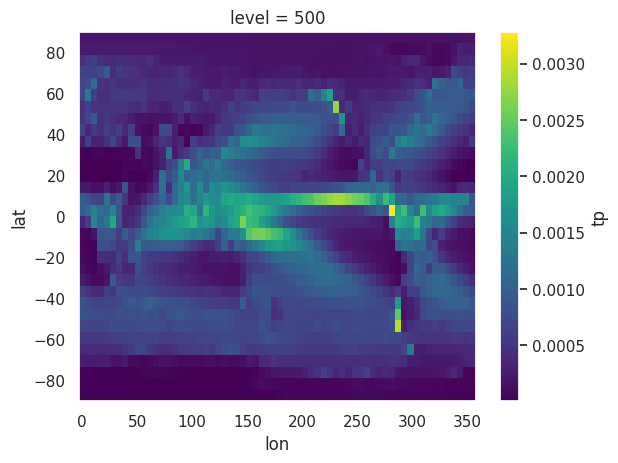

In [17]:
climatology.tp.plot();

In [18]:
print('Saving result:', f'{PREDDIR}/climatology_{res}.nc')
climatology.to_netcdf(  f'{PREDDIR}/climatology_{res}.nc')


Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/climatology_5.625.nc


## Climatology  forecast by week

We can create amuch better climatology by taking the seasonal cycle into account. Here we will do this by creating a separate climatology for every week.

In [19]:
def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [20]:
%%time 
print( f'[{datetime.now().replace(microsecond=0)}]' )
weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)

[2024-02-13 11:32:13]
CPU times: user 1min 6s, sys: 1min 13s, total: 2min 20s
Wall time: 2min 3s


In [21]:
weekly_climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    week     (time) int64 53 53 53 53 53 53 53 53 53 ... 52 52 52 52 52 52 52 52
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 5.043e+04 5.044e+04 ... 4.966e+04
    t        (time, lat, lon) float32 256.3 256.4 256.3 ... 251.3 251.3 251.3
    tp       (time, lat, lon) float32 1.057e-05 1.16e-05 ... 0.0001228 0.0001301
    t2m      (time, lat, lon) float32 247.2 246.9 246.6 ... 248.2 248.4 248.6

In [22]:
print ('Saving result:',     f'{PREDDIR}/weekly_climatology_{res}.nc')
weekly_climatology.to_netcdf(f'{PREDDIR}/weekly_climatology_{res}.nc')

Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/weekly_climatology_5.625.nc


### Reset everything 

In [23]:
IPython.Application.instance().kernel.do_shutdown(True)
IPython.Application.instance().kernel.do_shutdown(True)
client.shutdown()

### Note: 
Notebook 1b contains the same functions for higher resolution

# The End